# Text classification using Transformers.
This lab will still focus on text classification on the Imdb dataset.
In this lab session, we will focus on encoder-based transformer architecture, through the lens of the most famous model: **BERT**.

---

# Introduction

## HuggingFace

We have already experimented with some components provided by the HuggingFace library:
- the `datasets` library,
- the `tokenizer`.

Actually, HuggingFace library provides convenient API to deal with transformer models, like BERT, GPT, etc.  To quote their website: *Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models. Using pretrained models can reduce your compute costs, carbon footprint, and save you the time and resources required to train a model from scratch. Transformers support framework interoperability between PyTorch, TensorFlow, and JAX.*

## Goal of the lab session

We will experiment with the HuggingFace library. You'll have to load a model and to run it on your task.

Important things to keep in in minds are:
- Even if each model is a Transformer, they all have their peculiarities.
- What is the exact input format expected by the model?
- What is its exact output?
- Can you use the available model as is or should you make some modifications for your task?

These questions are actually part of the life of a NLP scientist. We will adress some of these questions in this lab and in the next lessons / labs / HW.

In [38]:
%%capture
!pip install transformers datasets

In [39]:
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer
from tqdm.notebook import tqdm


import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
DEVICE = torch.device('mps')
DEVICE

device(type='mps')

## Download the training data

In [40]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


## Prepare model inputs

The input format to BERT looks like it is  "over-specified", especially if you focus on just one type task: sequence classification, word tagging, paraphrase detection, etc. The format:
- Add special tokens to the start and end of each sentence.
- Pad & truncate all sentences to a single constant length.
- Explicitly differentiate real tokens from padding tokens with the "attention mask".

It looks like that:

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

If you don't want to recreate this kind of inputs with your own hands, you can use the pre-trained tokenizer associated to BERT. Moreover the function `encode_plus` will:
- Tokenize the sentence.
- Prepend the `[CLS]` token to the start.
- Append the `[SEP]` token to the end.
- Map tokens to their IDs.
- Pad or truncate the sentence to `max_length`
- Create attention masks for `[PAD]` tokens.


> 💡 *Note:* For computational reasons, we will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) model, which is a 40% smaller than the original BERT model but still achieve about 95% of the performances of the original model.

In [41]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

Let's see how the tokenizer actually process the sequence:

In [42]:
# Some useful steps:
message = "hello my name is kevin"
tok = tokenizer.tokenize(message)
print("Tokens in the sequence:", tok)
enc = tokenizer.encode(tok)
table = np.array(
    [
        enc,
        [tokenizer.ids_to_tokens[w] for w in enc],
    ]
).T
print("Encoded inputs:")
print(tabulate(table, headers=["Token IDs", "Tokens"], tablefmt="fancy_grid"))

Tokens in the sequence: ['hello', 'my', 'name', 'is', 'kevin']
Encoded inputs:
╒═════════════╤══════════╕
│   Token IDs │ Tokens   │
╞═════════════╪══════════╡
│         101 │ [CLS]    │
├─────────────┼──────────┤
│        7592 │ hello    │
├─────────────┼──────────┤
│        2026 │ my       │
├─────────────┼──────────┤
│        2171 │ name     │
├─────────────┼──────────┤
│        2003 │ is       │
├─────────────┼──────────┤
│        4901 │ kevin    │
├─────────────┼──────────┤
│         102 │ [SEP]    │
╘═════════════╧══════════╛


🚧 **Question** 🚧

You noticed special tokens like `[CLS]` and `[SEP]` in the sequence. Note how they were added automatically by HuggingFace.

- Why are there such special tokens?

**Answer**

Some of the special tokens are used to help the model understand the context of the sentence. For example, the `[CLS]` token is used to indicate the start of a sentence, while the `[SEP]` token is used to separate sentences or indicate the end of a sentence. These special tokens help the model learn the structure of the input data and make better predictions.

🚧 **TODO** 🚧

- Run the code below to make sure you can control this behavior

In [43]:
text = "my name is kevin"
tokenized_text_without_special_tokens = tokenizer.encode(text, add_special_tokens=False)
assert tokenized_text_without_special_tokens[0] != 101
print(tokenized_text_without_special_tokens)

[2026, 2171, 2003, 4901]


🚧 **TODO** 🚧

Explore the difference betweem between `encode` and `encode_plus`.
- can you explain the outputs ?
- do you know how to acces each of them ?

> 💡 *Note:* The output of `tokenizer.encode_plus(text)` is the same as `tokenizer(text).`

In [44]:
from prettytable import PrettyTable

In [45]:
encoded_text = tokenizer.encode(text)
encoded_text_plus = tokenizer.encode_plus(text)

table = PrettyTable()
table.field_names = ["Method", "Output"]
table.add_row(["encode", encoded_text])
table.add_row(["encode_plus", encoded_text_plus])
print(table)

+-------------+-----------------------------------------------------------------------------------------+
|    Method   |                                          Output                                         |
+-------------+-----------------------------------------------------------------------------------------+
|    encode   |                            [101, 2026, 2171, 2003, 4901, 102]                           |
| encode_plus | {'input_ids': [101, 2026, 2171, 2003, 4901, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]} |
+-------------+-----------------------------------------------------------------------------------------+


The `encode` method returns a dictionary without the `attention_mask` key. The `encode_plus` method returns a dictionary with the `attention_mask` key.

In [46]:
encoded_text_plus["attention_mask"]

[1, 1, 1, 1, 1, 1]

## Data pre-processing

Usual data-processing for torch. Same as previous lab.

In [47]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )
    x["labels"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [48]:
n_samples = 2000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "labels"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [49]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=256, return_tensors="pt"
        )
        return features

In [50]:
data_collator = DataCollator(tokenizer)

In [51]:
batch_size = 4

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

# Model from scratch

For this first exercise, we will start from a randomly initialized model.

## Retrieve the architecture configuration

In HuggingFace, model's parameters are specified through a `config` file. It is a json-like object.

We can retrieve the one from the official model with the following code:

In [52]:
from transformers import DistilBertConfig

model_config = DistilBertConfig.from_pretrained("distilbert-base-uncased")
print(model_config)

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.40.1",
  "vocab_size": 30522
}



🚧 **Question** 🚧

Make sure you understand the parameters of the configuration.
- Which ones are task-agnostic parameters?
- Which ones are not?
- Why are there different parameters for different tasks?

**Answer**

- The task-agnostic parameters are the ones that are common to all tasks, such as the number of layers, the hidden size, the number of attention heads, etc. These parameters are used to define the architecture of the model and are not specific to any particular task.
- The task-specific parameters are the ones that are specific to a particular task, such as the number of labels in a classification task, the number of classes in a token classification task, etc. These parameters are used to customize the model for a specific task and are not used in the general architecture of the model.
- There are different parameters for different tasks because each task has different requirements and constraints. For example, a classification task requires a different output layer than a token classification task, so the model needs to be able to adapt to these different requirements.



Several architectures are available for DistilBert on HuggingFace, designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained DistilBert model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForMaskedLM
* BertForNextSentencePrediction
* BertForSequenceClassification
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/docs/transformers/model_doc/distilbert).




🚧 **TODO** 🚧

For our first experiment, we want to build from a standard stack of transformer layers, without any additional task-specific head.

Which architecture is the corresponding one?

Choose the right one and initialize the model below, with the config.

In [53]:
from transformers import DistilBertModel

bert = DistilBertModel(model_config)

In [54]:
print(bert)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the cell below, we printed out the names and dimensions of the weights for:

- The embedding layer
- The first of the twelve transformers
- The output layer.



In [55]:
# Get all of the model's parameters as a list of tuples.
params = list(bert.named_parameters())

In [56]:
print("The BERT model has {:} different named parameters.\n".format(len(params)))

print("==== Embedding Layer ====\n")

for p in params[0:4]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("\n==== First Transformer Layer ====\n")

for p in params[4:20]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 100 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Transformer Layer ====

transformer.layer.0.attention.q_lin.weight                (768, 768)
transformer.layer.0.attention.q_lin.bias                      (768,)
transformer.layer.0.attention.k_lin.weight                (768, 768)
transformer.layer.0.attention.k_lin.bias                      (768,)
transformer.layer.0.attention.v_lin.weight                (768, 768)
transformer.layer.0.attention.v_lin.bias                      (768,)
transformer.layer.0.attention.out_lin.weight              (768, 768)
transformer.layer.0.attention.out_lin.bias                    (768,)
transformer.layer.0.sa_layer_norm.weight                 

🚧 **TODO** 🚧

Test your `bert`.
We can already try the model on the validation set. Before just look at the output of the model on one batch.
- Interpret the output.
- Do you understand everything ?


In [57]:
batch = next(iter(train_dataloader))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]

output = bert(input_ids, attention_mask)

print(output["last_hidden_state"].shape) # batch_size x seq_len x hidden_size
print(type(output))
print(output) # dict with keys "last_hidden_state", "hidden_states", "attentions"

torch.Size([4, 256, 768])
<class 'transformers.modeling_outputs.BaseModelOutput'>
BaseModelOutput(last_hidden_state=tensor([[[ 0.8651,  0.8982,  0.4881,  ..., -1.4687,  1.6095,  0.8335],
         [-0.2629,  0.5997,  1.2674,  ...,  0.1879, -1.2705, -0.1009],
         [ 2.0193,  0.4267,  1.1653,  ...,  0.7345,  0.2166,  0.5249],
         ...,
         [-1.5081, -1.7957,  0.7671,  ..., -1.0657,  0.3830, -0.5685],
         [ 0.3010, -0.2578, -0.2902,  ...,  0.4349,  1.5192, -0.0120],
         [-1.1544,  0.0638, -0.7312,  ..., -0.1273,  0.7448, -1.3094]],

        [[ 1.0070,  0.9488,  1.1372,  ..., -0.0198,  1.0691,  1.6227],
         [-0.1592,  0.3141,  1.1194,  ..., -1.2880,  0.7257,  0.5229],
         [ 0.0040, -0.7562,  1.0398,  ...,  1.5272, -0.3932,  0.4565],
         ...,
         [-0.6553, -1.3326,  0.8687,  ..., -1.6343,  1.1106, -0.0456],
         [-0.1064, -1.1593,  0.1036,  ..., -0.2574,  0.8409,  0.0724],
         [-0.4837,  0.0874,  0.9165,  ..., -0.5933,  1.5892, -0.9193]],



## Building a classifier

Our `bert` model is simply a stack of transformer layers. We would like to use it as a backbone for text classification.

🚧 **TODO** 🚧

Wraps the model into a classifier.

> 💡 *Hint*: Use the last hidden [CLS] vector representation to perform classification.

In [58]:
class DistilBertClassifier(nn.Module):
    def __init__(self, bert, dropout=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = bert 
        self.dp = nn.Dropout(dropout)
        self.classifier = nn.Linear(768,1)
        
        
    def forward(self, input_ids, attention_mask):
        bert_out =  self.bert( input_ids, attention_mask)
        out = bert_out["last_hidden_state"]
        out = self.dp(out[:,0])
        return self.classifier(out)

In [59]:
bert = DistilBertModel(model_config)
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

🚧 **TODO** 🚧

Test your model on the batch.
Make sure it has the right shape.

In [60]:
input_ids = input_ids.to(DEVICE)
attention_mask = attention_mask.to(DEVICE)
out = model.forward(input_ids, attention_mask)
print(out)

tensor([[-0.6426],
        [-0.5294],
        [-0.8928],
        [-0.2851]], device='mps:0', grad_fn=<LinearBackward0>)


### Training

🚧 **TODO** 🚧

Train your model.
Make sure you track the following quantities per epoch:
- training loss
- training accuracy
- validation loss
- validation accuracy

In [61]:
# Redefine the dataloaders to adjust the batch size.
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [62]:
def validation(model, valid_dataloader):
    total_size = 0
    acc_total = 0
    loss_total = 0
    criterion = nn.BCEWithLogitsLoss()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids = batch["input_ids"]
            labels = batch["labels"]
            attention_mask = batch["attention_mask"]
            labels = labels.float()
            preds = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(preds.squeeze(), labels)
            acc = (preds.squeeze() > 0) == labels
            total_size += acc.shape[0]
            acc_total += acc.sum().item()
            loss_total += loss.item()
    model.train()
    return loss_total / len(valid_dataloader), acc_total / total_size


validation(model, valid_dataloader)

  0%|          | 0/13 [00:00<?, ?it/s]

(0.7271014085182776, 0.505)

In [63]:
def training(model, n_epochs, train_dataloader, valid_dataloader, lr=5e-5):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        eps=1e-08,
    )
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []
    criterion = nn.BCEWithLogitsLoss()
    for e in range(n_epochs):
        # ========== Training ==========

        # Set model to training mode
        model.train()
        model.to(DEVICE)

        # Tracking variables
        train_loss = 0
        epoch_train_acc = 0
        for batch in tqdm(train_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            input_ids, attention_mask, labels = (
                batch["input_ids"],
                batch["attention_mask"],
                batch["labels"],
            )
            optimizer.zero_grad()
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Backward pass
            loss = criterion(outputs.squeeze(), labels.squeeze().float())
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            acc = (outputs.squeeze() > 0) == labels.squeeze()
            epoch_train_acc += acc.float().mean().item()
        list_train_acc.append(100 * epoch_train_acc / len(train_dataloader))
        list_train_loss.append(train_loss / len(train_dataloader))

        # ========== Validation ==========

        l, a = validation(model, valid_dataloader)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)
        """
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
        """
        table = PrettyTable()
        table.field_names = ["Epoch", "Train loss", "Train acc", "Val loss", "Val acc"]
        for i in range(e + 1):
            table.add_row(
                [
                    i,
                    "{:.4f}".format(list_train_loss[i]),
                    "{:.4f}".format(list_train_acc[i]),
                    "{:.4f}".format(list_val_loss[i]),
                    "{:.4f}".format(list_val_acc[i]),
                ]
            )
        print(table)
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [64]:
# training(model, 3, train_dataloader, valid_dataloader)

In [65]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 10, train_dataloader, valid_dataloader
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
|   5   |   0.0392   |  98.9375  |  0.9142  | 78.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
|   5   |   0.0392   |  98.9375  |  0.9142  | 78.2500 |
|   6   |   0.0027   |  100.0000 |  1.0487  | 80.0000 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
|   5   |   0.0392   |  98.9375  |  0.9142  | 78.2500 |
|   6   |   0.0027   |  100.0000 |  1.0487  | 80.0000 |
|   7   |   0.0003   |  100.0000 |  1.0942  | 80.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
|   5   |   0.0392   |  98.9375  |  0.9142  | 78.2500 |
|   6   |   0.0027   |  100.0000 |  1.0487  | 80.0000 |
|   7   |   0.0003   |  100.0000 |  1.0942  | 80.2500 |
|   8   |   0.0006   |  100.0000 |  1.2960  | 76.7500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.7406   |  52.3125  |  0.6855  | 54.7500 |
|   1   |   0.6039   |  65.8125  |  0.5933  | 70.2500 |
|   2   |   0.3470   |  83.7500  |  0.6978  | 71.2500 |
|   3   |   0.1595   |  93.5625  |  0.6140  | 78.2500 |
|   4   |   0.1195   |  95.3750  |  0.7244  | 75.5000 |
|   5   |   0.0392   |  98.9375  |  0.9142  | 78.2500 |
|   6   |   0.0027   |  100.0000 |  1.0487  | 80.0000 |
|   7   |   0.0003   |  100.0000 |  1.0942  | 80.2500 |
|   8   |   0.0006   |  100.0000 |  1.2960  | 76.7500 |
|   9   |   0.0011   |  99.9375  |  1.2509  | 79.2500 |
+-------+------------+-----------+----------+---------+


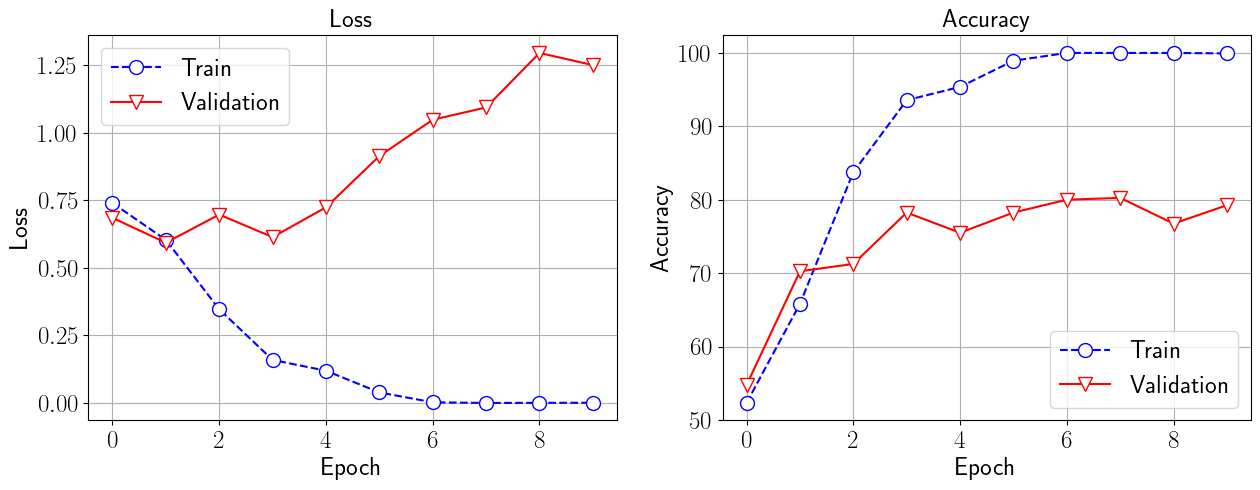

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax[0].plot(list_train_loss, marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(list_val_loss, marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_title("Loss")
ax[0].legend(["Train", "Validation"])
ax[0].grid(grid)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(list_train_acc, marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(list_val_acc, marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_title("Accuracy")
ax[1].legend(["Train", "Validation"])
ax[1].grid(grid)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

🚧 **Question** 🚧

How does it compare with your convolution model from previous lab?


## Pre-trained model

Now we are going to compare with a pre-trained model.

First, we are going to load the model's weights from the HuggingFace hub.

In [72]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")

## Fine-Tuning

With our model loaded and ready,  we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

- Batch size: 16, 32  
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  
- Number of epochs: 2, 3, 4

We chose:
* **Batch size**: 16 (set when creating our DataLoaders)
* **Learning rate**: 5e-5
* **Epochs**: 3 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

🚧 **TODO** 🚧

Build the classifier and train it with the pre-trained checkpoint.

In [75]:
class DistilBertClassifier(nn.Module):
    def __init__(self, bert, dropout=0.1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = bert
        self.dp = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids, attention_mask)
        out = bert_out["last_hidden_state"]
        out = self.dp(out[:, 0])
        return self.classifier(out)

In [76]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
model = DistilBertClassifier(bert)
model.to(DEVICE)

DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [77]:
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model, 5, train_dataloader, valid_dataloader
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.4976   |  74.1250  |  0.3515  | 83.7500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.4976   |  74.1250  |  0.3515  | 83.7500 |
|   1   |   0.2482   |  90.1875  |  0.5466  | 82.7500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.4976   |  74.1250  |  0.3515  | 83.7500 |
|   1   |   0.2482   |  90.1875  |  0.5466  | 82.7500 |
|   2   |   0.1460   |  95.0000  |  0.8387  | 75.2500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.4976   |  74.1250  |  0.3515  | 83.7500 |
|   1   |   0.2482   |  90.1875  |  0.5466  | 82.7500 |
|   2   |   0.1460   |  95.0000  |  0.8387  | 75.2500 |
|   3   |   0.0994   |  96.8750  |  0.4822  | 85.7500 |
+-------+------------+-----------+----------+---------+


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

+-------+------------+-----------+----------+---------+
| Epoch | Train loss | Train acc | Val loss | Val acc |
+-------+------------+-----------+----------+---------+
|   0   |   0.4976   |  74.1250  |  0.3515  | 83.7500 |
|   1   |   0.2482   |  90.1875  |  0.5466  | 82.7500 |
|   2   |   0.1460   |  95.0000  |  0.8387  | 75.2500 |
|   3   |   0.0994   |  96.8750  |  0.4822  | 85.7500 |
|   4   |   0.1251   |  95.6250  |  0.5571  | 83.5000 |
+-------+------------+-----------+----------+---------+


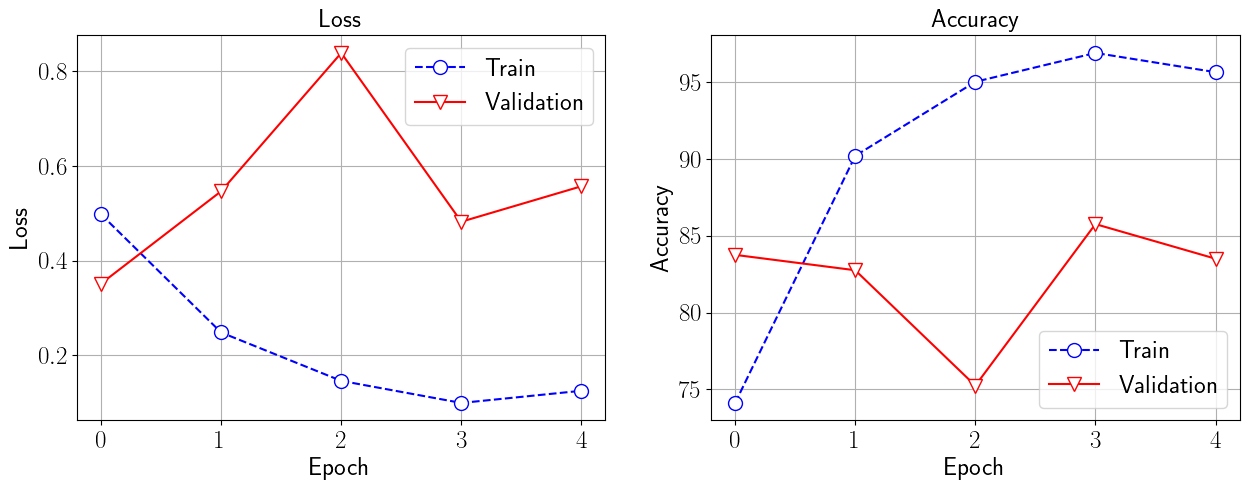

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
marker = ["o", "v"]
color = ["blue", "red"]
linestyle = ["--", "-"]
markerfacecolor = ["white", "white"]
markersize = 10
grid = True
ax[0].plot(list_train_loss, marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[0].plot(list_val_loss, marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[0].set_title("Loss")
ax[0].legend(["Train", "Validation"])
ax[0].grid(grid)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(list_train_acc, marker=marker[0], color=color[0], linestyle=linestyle[0], markerfacecolor=markerfacecolor[0], markersize=markersize)
ax[1].plot(list_val_acc, marker=marker[1], color=color[1], linestyle=linestyle[1], markerfacecolor=markerfacecolor[1], markersize=markersize)
ax[1].set_title("Accuracy")
ax[1].legend(["Train", "Validation"])
ax[1].grid(grid)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
plt.show()

🚧 **Question** 🚧

What do you think of the results?

**Answer**

TODO

## Pre-built models

Actually, you built your own classifier based on the raw output of a transformers, wrapped into a classification model.

But, for many tasks, you can directly download the model with the necessary blocks.

For instance, we could directly have loaded `DistilBertForSequenceClassification`.

Let's see the difference with our model.

🚧 **TODO** 🚧

Load a pre-trained `DistilBertForSequenceClassification`.

In [84]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

🚧 **Question** 🚧

Here there might be a lot of questions:
- what does the warning means?
- why `num_labels=1`?
- and the other options?

**Answer**

TODO

🚧 **Question** 🚧

How is the classifcation made? Is it the same than with our model? You might need to check the official implementation [here](https://github.com/huggingface/transformers/blob/v4.34.1/src/transformers/models/distilbert/modeling_distilbert.py#L730).

**Answer**

TODO

🚧 **TODO** 🚧

The output of such a model is not directly the logits, but a wrapper that can return several objects. Analyze it and modify the training and validation loop accordingly.

Launch the training.

Do you observe any differences with our own classification model?

In [87]:
model.to(DEVICE)
batch = {k: v.to(DEVICE) for k, v in next(iter(train_dataloader)).items()}
output = model(**batch)

In [88]:
output

SequenceClassifierOutput(loss=tensor(0.6890, device='mps:0', grad_fn=<NllLossBackward0>), logits=tensor([[-0.0140,  0.0457],
        [ 0.0670,  0.0958],
        [ 0.0127,  0.0663],
        [-0.0298,  0.0268],
        [ 0.0157,  0.0814],
        [-0.0090,  0.0817],
        [ 0.0060,  0.0523],
        [ 0.0186,  0.0649],
        [ 0.0787,  0.0669],
        [ 0.0510,  0.1260],
        [ 0.0236,  0.0506],
        [ 0.0399,  0.0917],
        [ 0.0002,  0.0805],
        [-0.0017,  0.0200],
        [ 0.0269,  0.1208],
        [ 0.0626,  0.0349],
        [ 0.0069,  0.0922],
        [-0.0836,  0.0819],
        [ 0.0303,  0.0272],
        [-0.0441,  0.0226],
        [ 0.0177,  0.0588],
        [-0.0256,  0.0725],
        [ 0.0413, -0.0017],
        [ 0.0477,  0.0339],
        [ 0.1082,  0.0638],
        [-0.0713,  0.0015],
        [ 0.1036,  0.1597],
        [-0.0470,  0.1311],
        [ 0.0626,  0.0884],
        [-0.0554,  0.1218],
        [-0.0142,  0.1215],
        [ 0.0385,  0.0093]], device

# Interpretability

So far we have models able to predict quite faithfully if a critic is positive or negative. But can we interprete the results?

A usual way to do so with transformers, is simply to look at the **attention weights**. Let's see if we can get some insights on the model's prediction using this technique.


First, tokenize the text.

In [139]:
text = ("This is the best movie I have ever seen")
tokenized_text = tokenizer(text, return_tensors="pt")

🚧 **TODO** 🚧

Now feed it as an output for the model. Use the keyword-argument `output_attentions=True`.


In [140]:
model.to(DEVICE)
tokenized_text = {k: v.to(DEVICE) for k, v in tokenized_text.items()}
model_output = model(**tokenized_text, output_attentions=True)

🚧 **TODO** 🚧 
Check the prediction and plot the attention weights matrix.

In [147]:
def classify(text, model, tokenizer):
    tokenized_text = tokenizer(text, return_tensors="pt")
    tokenized_text = {k: v.to(DEVICE) for k, v in tokenized_text.items()}
    model_output = model(**tokenized_text, output_attentions=True)
    logit = model_output.logits
    prob = F.softmax(logit, dim=1)
    print("Prediction:", "😊" if prob[0, 1] > 0.5 else "😞")
    
    attentions = model_output.attentions
    attentions = torch.cat(attentions, dim=1)
    attentions = attentions.mean(dim=1).squeeze().cpu().detach().numpy()
    plt.imshow(attentions, cmap="Blues")
    plt.xticks(range(len(tokenized_text["input_ids"].squeeze())), [tokenizer.decode([w]) for w in tokenized_text["input_ids"].squeeze()], rotation=90, fontsize=10)
    plt.show()

Prediction: 😞


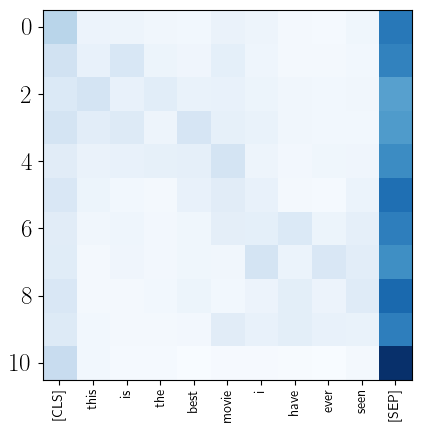

In [148]:
classify(text, model, tokenizer)

🚧 **Question** 🚧

Is your interpretability experiment conclusive?